# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

In [ ]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
torch.__version__

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

### Create model

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

### Train Model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

### Save Model State Dict
This is the [currently recommended save format](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference).

In [ ]:
torch.save(model.state_dict(), "model_weights.pt")
print("Saved PyTorch Model State to model_weights.pt")

### Save Entire Model
This saves the entire model using python pickle, but has the [following disadvantage](https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model):
> The serialized data is bound to the specific classes and the exact directory structure used when the model is saved... Because of this, your code can break in various ways when used in other projects or after refactors.

In [ ]:
torch.save(model, "model.pt")

### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python).  However, this currently doesn't work with spark, which uses pickle serialization.

In [ ]:
scripted = torch.jit.script(model)

In [ ]:
scripted.save("model.ts")

### Load Model State

In [ ]:
model_from_state = NeuralNetwork()
model_from_state.load_state_dict(torch.load("model_weights.pt"))

In [ ]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

### Load Model

In [ ]:
new_model = torch.load("model.pt")

In [ ]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = new_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

### Load Torchscript Model

In [ ]:
ts_model = torch.jit.load("model.ts")

In [ ]:
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = ts_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

## PySpark

### Convert numpy dataset to Pandas DataFrame

In [ ]:
import pandas as pd
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [ ]:
data = test_data.data.numpy()
data.shape, data.dtype

In [ ]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

In [ ]:
pdf784 = pd.DataFrame(data)
pdf784

In [ ]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

In [ ]:
### Create Spark DataFrame from Pandas DataFrame

In [ ]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema)

In [ ]:
df.schema

In [ ]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema)

### Save the test dataset as parquet files

In [ ]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

In [ ]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

### Check arrow memory configuration

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sparkext
import torch

from pathlib import Path
from torch import nn

In [ ]:
df = spark.read.parquet("fashion_mnist_1")

In [ ]:
df.show(truncate=80)

### Using TorchScript Model
TorchScript models do not require the model definition prior to loading, but they don't serialize well from Spark driver to executors, so we must use a `model_loader` function that is invoked on the executor.

In [ ]:
def model_loader(path: str):
    return torch.jit.load(path)

In [ ]:
model_path = Path.cwd() / "model.ts"
model_path

In [ ]:
model = sparkext.torch.Model(str(model_path), model_loader) \
            .setInputCol("data") \
            .setOutputCol("preds") \
            .setInputShape((-1,28,28))

In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

In [ ]:
%%time
preds = predictions.collect()

In [ ]:
preds[0].preds

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
img = np.array(preds[0].data)

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()

### Using Saved Model

Since the model is pickled, the model class must be defined before loading.

In [ ]:
# Get cpu or gpu device for training.
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = sparkext.torch.Model("model.pt") \
            .setInputCol("data") \
            .setOutputCol("preds") \
            .setInputShape((-1,28,28))

In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

In [ ]:
preds[0]['preds']

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
img = np.array(preds[0].data)

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()

In [ ]:
%%time
preds = predictions.collect()

## Inference using Spark DL UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pathlib import Path
from pyspark.sql.functions import col
from sparkext.torch import model_udf

In [ ]:
df = spark.read.parquet("fashion_mnist_test")

### Using TorchScript Model
TorchScript models do not require the model definition prior to loading, but they don't serialize well from Spark driver to executors, so we must use a `model_loader` function that is invoked on the executor.

In [ ]:
def model_loader(path: str):
    import torch
    return torch.jit.load(path)

In [ ]:
model_path = Path.cwd() / "model.ts"
model_path

In [ ]:
classify = model_udf(str(model_path), model_loader=model_loader)

In [ ]:
predictions = df.withColumn("preds", classify(col("data")))

In [ ]:
%%time
preds = predictions.collect()

In [ ]:
preds[0].preds

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
img = np.array(preds[0].data)

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()

### Using Saved Model

Since the model is pickled, the model class must be defined before loading.

In [ ]:
from torch import nn

# Get cpu or gpu device for training.
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
classify = model_udf("model.pt")

In [ ]:
preds = df.withColumn("preds", classify(col("data"))).collect()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = np.array(preds[0].data)

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
preds[0].preds

## Inference using Triton UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = spark.read.parquet("fashion_mnist_1")

In [ ]:
df.schema

In [ ]:
from sparkext.triton.udf import model_udf

In [ ]:
mnist = model_udf("localhost:8001", "fashion_mnist", batch_size=4)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

### Check predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
index = 0
img = np.array(preds[index].data)
predictions = preds[index].preds

In [ ]:
plt.figure()
plt.imshow(img.reshape(28,28))
plt.show()

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [ ]:
predictions

## Inference using Spark DL API

### 1 columns of 784 float

In [1]:
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [2]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [3]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [4]:
def predict_batch_fn():
    import torch
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("Using {} device".format(device))
    model = torch.jit.load("/home/leey/devpub/leewyang/sparkext/examples/pytorch/model.ts")
    model.to(device)
    
    def predict(inputs: np.ndarray):
        torch_inputs = torch.from_numpy(inputs).to(device)
        outputs = model(torch_inputs)
        return outputs.detach().numpy()
    
    return predict

In [5]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[-1, 784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [6]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 503 ms, sys: 142 ms, total: 645 ms
Wall time: 7.7 s


In [7]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 472 ms, sys: 131 ms, total: 602 ms
Wall time: 3.49 s


In [8]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 629 ms, sys: 105 ms, total: 734 ms
Wall time: 3.4 s


### Check predictions

In [9]:
predictions = preds[0].preds
img = preds[0].data

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
img = np.array(img).reshape(28,28)

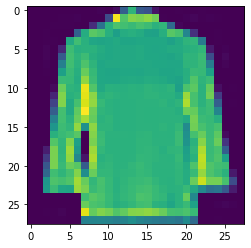

In [12]:
plt.figure()
plt.imshow(img)
plt.show()

In [13]:
predictions

[0.9588213562965393,
 -2.071481943130493,
 2.1429624557495117,
 -0.4603125751018524,
 2.076378107070923,
 -1.5263869762420654,
 2.026245594024658,
 -2.510979175567627,
 1.5055983066558838,
 -1.3217121362686157]

### 784 columns of float

In [14]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [15]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

22/09/21 08:50:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


CPU times: user 1.09 s, sys: 139 ms, total: 1.23 s
Wall time: 10.3 s


In [16]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 983 ms, sys: 176 ms, total: 1.16 s
Wall time: 5.24 s


In [17]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

22/09/21 08:51:11 WARN TaskSetManager: Lost task 0.0 in stage 7.0 (TID 42) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/leewyang/spark/python/pyspark/ml/functions.py", line 289, in predict
    raise ValueError(
ValueError: Multiple input columns found, but model expected a single input, use `struct` or `array` to combine columns into tensors.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:108)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:52)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at s

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/leewyang/spark/python/pyspark/ml/functions.py", line 289, in predict
    raise ValueError(
ValueError: Multiple input columns found, but model expected a single input, use `struct` or `array` to combine columns into tensors.


In [18]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

22/09/21 08:51:18 WARN TaskSetManager: Lost task 1.0 in stage 8.0 (TID 51) (192.168.86.223 executor 0): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/leey/devpub/leewyang/spark/python/pyspark/ml/functions.py", line 289, in predict
    raise ValueError(
ValueError: Multiple input columns found, but model expected a single input, use `struct` or `array` to combine columns into tensors.

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:559)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:108)
	at org.apache.spark.sql.execution.python.PythonArrowOutput$$anon$1.read(PythonArrowOutput.scala:52)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:512)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at s

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/leey/devpub/leewyang/spark/python/pyspark/ml/functions.py", line 289, in predict
    raise ValueError(
ValueError: Multiple input columns found, but model expected a single input, use `struct` or `array` to combine columns into tensors.


### Check predictions

In [19]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [20]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
img = np.array(img).reshape(28,28)

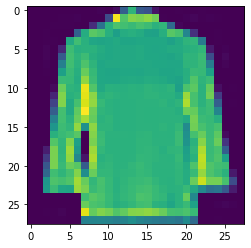

In [23]:
plt.figure()
plt.imshow(img)
plt.show()

In [24]:
predictions

[0.9588213562965393,
 -2.071481943130493,
 2.1429624557495117,
 -0.4603125751018524,
 2.076378107070923,
 -1.5263869762420654,
 2.026245594024658,
 -2.510979175567627,
 1.5055983066558838,
 -1.3217121362686157]

### Using Triton Server

In [25]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [26]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [27]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

#### Start Triton Server on each executor

In [28]:
num_executors = 1

nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:22.07-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={"/home/leey/devpub/leewyang/sparkext/examples/models": {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.mapPartitions(start_triton).collect()

[True]

#### Run inference

In [29]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [30]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[-1, 784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=8)

In [31]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 427 ms, sys: 106 ms, total: 533 ms
Wall time: 2.69 s


In [32]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 530 ms, sys: 74.5 ms, total: 605 ms
Wall time: 1.39 s


In [33]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 625 ms, sys: 87.9 ms, total: 713 ms
Wall time: 1.44 s


#### Stop Triton Server on each executor

In [34]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.mapPartitions(stop_triton).collect()

[True]

In [35]:
spark.stop()

Traceback (most recent call last):
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/leey/.pyenv/versions/3.9.10/envs/spark_dev/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/home/leey/.pyenv/versions/3.9.10/lib/python3